In [420]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import time

In [421]:
data = pd.read_csv("iris.csv")

x = data.drop(['species'], axis=1)
y = data['species']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=48)

In [422]:
x_train.shape

(120, 4)

In [423]:
y_train.shape

(120,)

In [424]:
class KNN:
    def __init__(self, k=1):
        self.y_train = None
        self.X_train = None
        self.k = k
        
    def fit(self, X_train, y_train):
        self.X_train, self.y_train = np.array(X_train), np.array(y_train)

    @staticmethod
    def gaussian_kernel(u):
        return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * (u**2))
    
    def euclidean_distances(self, x_new):
            return np.sqrt(np.sum((self.X_train - x_new) ** 2, axis=1))
    
    def make_prediction(self, x_new):
        distances = self.euclidean_distances(x_new)
        
        weights = {}
        for i in range(len(self.X_train)):
            mark = self.y_train[i]
            index_k_plus_1 = np.argsort(distances)[:self.k+1][-1]
            r = distances[i] / (distances[index_k_plus_1] + 1e-12)
            
            try:
                weights[mark] += self.gaussian_kernel(r)
            except KeyError:
                weights[mark] = self.gaussian_kernel(r)
        max = 0
        max_key = 0
        for key, value in weights.items():
            if value > max:
                max_key = key
                max = value
        return max_key
    
    def predict(self, X_test):
        return pd.Series([self.make_prediction(x) for x in np.array(X_test)])

In [425]:
class LOO:
    def __init__(self, model, k):
        self.best_param = None
        self.model = model
        self.k = k
        self.errors = {}

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n = len(X)
    
        for k_value in range(1, self.k):
            self.model.k = k_value
            err_count = 0
            for i in range(n):
                X_train = np.concatenate((X[:i], X[i+1:]), axis=0)
                y_train = np.concatenate((y[:i], y[i+1:]), axis=0)
                
                x_array = X[i]
                x_test = pd.DataFrame([x_array], columns=[str(i) for i in range(len(x_array))])
                y_test = y[i]
    
                self.model.fit(X_train, y_train)
                y_pred = self.model.predict(x_test)
                if y_pred[0] != pd.Series(y_test)[0]:
                    err_count += 1
            
            self.errors[k_value] = err_count / n
        
        min = 10 ** 9
        min_key = 0
        for key, value in self.errors.items():
            if value <= min:
                min_key = key
                min = value

        self.best_param = min_key


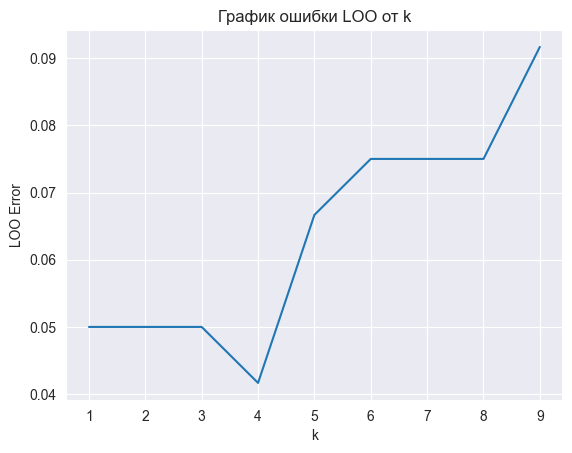

Оптимальное k по LOO = 4


In [426]:
errors_loo = LOO(KNN(), k = 10)
errors_loo.fit(x_train, y_train)

graph = errors_loo.errors.values()
plt.plot([_ for _ in range(1, 10)], graph)
plt.xlabel('k')
plt.ylabel('LOO Error')
plt.title('График ошибки LOO от k')
plt.show()

print("Оптимальное k по LOO =", errors_loo.best_param)

In [427]:
custom_knn = KNN(k=4)
custom_knn.fit(x_train, y_train)

start_time = time.time()
custom_predictions = custom_knn.predict(x_test)
custom_time = time.time() - start_time

sklearn_knn = KNeighborsClassifier(n_neighbors=4)
sklearn_knn.fit(x_train, y_train)

start_time = time.time()
sklearn_predictions = sklearn_knn.predict(x_test)
sklearn_time = time.time() - start_time

custom_precision = precision_score(y_test, custom_predictions, average='macro')
custom_recall = recall_score(y_test, custom_predictions, average='macro')
custom_accuracy = accuracy_score(y_test, custom_predictions)

sklearn_precision = precision_score(y_test, sklearn_predictions, average='macro')
sklearn_recall = recall_score(y_test, sklearn_predictions, average='macro')
sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)

print("Custom KNN:")
print(f"Precision: {custom_precision:.4f}")
print(f"Recall: {custom_recall:.4f}")
print(f"Accuracy: {custom_accuracy:.4f}")
print(f"Time: {custom_time:.4f} seconds")

print("\nSklearn KNN:")
print(f"Precision: {sklearn_precision:.4f}")
print(f"Recall: {sklearn_recall:.4f}")
print(f"Accuracy: {sklearn_accuracy:.4f}")
print(f"Time: {sklearn_time:.4f} seconds")

Custom KNN:
Precision: 0.9074
Recall: 0.9030
Accuracy: 0.9000
Time: 0.0300 seconds

Sklearn KNN:
Precision: 0.9364
Recall: 0.9364
Accuracy: 0.9333
Time: 0.0040 seconds
